In [27]:
import numpy as np
import pandas as pd
import nltk
import re
import string
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_val_score,train_test_split
import math
import spacy
import en_core_web_sm
import itertools
from sklearn.metrics import mean_squared_error

In [41]:
df_train = pd.read_csv('train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('test.csv', encoding="ISO-8859-1")
df_pro_desc = pd.read_csv('product_descriptions.csv',encoding="ISO-8859-1")
df_train_desc = pd.merge(df_train, df_pro_desc, how='left', on='product_uid')
df_train_all = df_train_desc
df_train_all

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...
...,...,...,...,...,...,...
74062,221457,206638,Atlantic Windowpane 576 CD or 192 DVD Blu-Ray ...,tv riser glass,1.00,"Atlantic, Inc. 94835722 Uniquely designed for ..."
74063,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (...,r20 halogen light,3.00,Philips Energy Advantage lamps use less energy...
74064,221463,206641,Schlage Camelot In-Active Aged Bronze Handlese...,schlage lock siena half dummy knob with,2.33,The Schlage Camelot In-Active Aged Bronze Hand...
74065,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor...,zen garden decor,3.00,The Rose Garden is inspired by the popular ear...


In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
def clean_text(text):
    stopwords = nltk.corpus.stopwords.words('english')
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

df_train_all['product_title'] = df_train_small['product_title'].apply(lambda x: clean_text(x.lower()))
df_train_all['search_term'] = df_train_small['search_term'].apply(lambda x: clean_text(x.lower()))
df_train_all['product_description'] = df_train_small['product_description'].apply(lambda x: clean_text(x.lower()))
df_train_all

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,"[simpson, strongtie, 12gauge, angle]","[angle, bracket]",3.00,"[angles, make, joints, stronger, also, provide..."
1,3,100001,"[simpson, strongtie, 12gauge, angle]","[l, bracket]",2.50,"[angles, make, joints, stronger, also, provide..."
2,9,100002,"[behr, premium, textured, deckover, 1gal, sc14...",[deck],3.00,"[behr, premium, textured, deckover, innovative..."
3,16,100005,"[delta, vero, 1handle, shower, faucet, trim, k...","[rain, shower, head]",2.33,"[update, bathroom, delta, vero, singlehandle, ..."
4,17,100005,"[delta, vero, 1handle, shower, faucet, trim, k...","[shower, faucet]",2.67,"[update, bathroom, delta, vero, singlehandle, ..."
...,...,...,...,...,...,...
74062,221457,206638,"[atlantic, windowpane, 576, cd, 192, dvd, blur...","[tv, riser, glass]",1.00,"[atlantic, inc, 94835722, uniquely, designed, ..."
74063,221458,206639,"[philips, 40watt, halogen, r20, flood, light, ...","[r20, halogen, light]",3.00,"[philips, energy, advantage, lamps, use, less,..."
74064,221463,206641,"[schlage, camelot, inactive, aged, bronze, han...","[schlage, lock, siena, half, dummy, knob]",2.33,"[schlage, camelot, inactive, aged, bronze, han..."
74065,221471,206648,"[plastec, 11, x, 24, rose, garden, wall, decor...","[zen, garden, decor]",3.00,"[rose, garden, inspired, popular, early, 20th,..."


In [11]:
#stemming
ps = nltk.PorterStemmer() # define stemmer
df_all_stem = pd.DataFrame()

def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]  #return stemmed word
    return text
df_all_stem['id'] = df_train_small['id']
df_all_stem['product_uid'] = df_train_small['product_uid']
df_all_stem['product_title'] = df_train_small['product_title'].apply(lambda x: stemming(x))
df_all_stem['search_term'] = df_train_small['search_term'].apply(lambda x: stemming(x))
df_all_stem['product_description'] = df_train_small['product_description'].apply(lambda x: stemming(x))
df_all_stem['relevance'] = df_train_small['relevance']
df_all_stem.head()

,id,product_uid,product_title,search_term,product_description,relevance
0,2,100001,"[simpson, strongti, 12gaug, angl]","[angl, bracket]","[angl, make, joint, stronger, also, provid, co...",3.00
1,3,100001,"[simpson, strongti, 12gaug, angl]","[l, bracket]","[angl, make, joint, stronger, also, provid, co...",2.50
2,9,100002,"[behr, premium, textur, deckov, 1gal, sc141, t...",[deck],"[behr, premium, textur, deckov, innov, solid, ...",3.00
3,16,100005,"[delta, vero, 1handl, shower, faucet, trim, ki...","[rain, shower, head]","[updat, bathroom, delta, vero, singlehandl, sh...",2.33
4,17,100005,"[delta, vero, 1handl, shower, faucet, trim, ki...","[shower, faucet]","[updat, bathroom, delta, vero, singlehandl, sh...",2.67


In [60]:
df_all_features = pd.DataFrame()

def str_common_word(list1, list2):
    list3 = set(list1)&set(list2) 
    list4 = sorted(list3, key = lambda k : list1.index(k))
    return len(list4)


df_all_features['search_term'] = df_all_stem['search_term']
df_all_features['product_title'] = df_all_stem['product_title']
df_all_features['product_description'] = df_all_stem['product_description']

df_all_features['product_info'] = df_all_features.values.tolist()
df_all_features['id'] = df_train_small['id']
df_all_features['product_uid'] = df_train_small['product_uid']
df_all_features['len_of_query'] = df_all_features['search_term'].map(lambda x:len(x)).astype(np.int64)
df_all_features['word_in_title'] = df_all_features['product_info'].map(lambda x:str_common_word(x[0],x[1]))
df_all_features['word_in_description'] = df_all_features['product_info'].map(lambda x:str_common_word(x[0],x[2]))
#df_all_features = df_all_features.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_all_features.head()

,search_term,product_title,product_description,product_info,id,product_uid,len_of_query,word_in_title,word_in_description
0,"[angl, bracket]","[simpson, strongti, 12gaug, angl]","[angl, make, joint, stronger, also, provid, co...","[[angl, bracket], [simpson, strongti, 12gaug, ...",2,100001,2,1,1
1,"[l, bracket]","[simpson, strongti, 12gaug, angl]","[angl, make, joint, stronger, also, provid, co...","[[l, bracket], [simpson, strongti, 12gaug, ang...",3,100001,2,0,0
2,[deck],"[behr, premium, textur, deckov, 1gal, sc141, t...","[behr, premium, textur, deckov, innov, solid, ...","[[deck], [behr, premium, textur, deckov, 1gal,...",9,100002,1,0,1
3,"[rain, shower, head]","[delta, vero, 1handl, shower, faucet, trim, ki...","[updat, bathroom, delta, vero, singlehandl, sh...","[[rain, shower, head], [delta, vero, 1handl, s...",16,100005,3,1,1
4,"[shower, faucet]","[delta, vero, 1handl, shower, faucet, trim, ki...","[updat, bathroom, delta, vero, singlehandl, sh...","[[shower, faucet], [delta, vero, 1handl, showe...",17,100005,2,2,2


In [13]:
#import the Word2Vec embedding features
emb_features = pd.read_csv("HD_embedding.csv")
emb_features.head()

,Unnamed: 0,title_sim,description_sim
0,0,0.099485,0.011724
1,1,0.056404,0.009350
2,2,0.043307,0.011489
3,3,0.036266,0.009092
4,4,0.077293,0.016911


In [75]:
#add the embedding features
#df_all_features_emb = pd.concat([df_all_features, emb_features], axis=1)
df_all_features_emb = df_all_features
df_all_features_emb['relevance'] = df_train_all['relevance']
df_all_features_emb = df_all_features_emb.drop(['search_term','product_title','product_description','product_info','product_uid','id','relevance'],axis=1)
df_all_features_emb

,len_of_query,word_in_title,word_in_description
0,2,1,1
1,2,0,0
2,1,0,1
3,3,1,1
4,2,2,2
...,...,...,...
74062,3,1,1
74063,3,3,2
74064,6,1,1
74065,3,2,2


##Try TF-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import FeatureUnion, Pipeline
# TF-IDF and Truncated SVD initialization (to extract concept using Latent semantics analysis(LSA))
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english') #stop words
svd = TruncatedSVD(n_components=100, random_state = 2019)  #n_components=100 to extract concepts using LSA
pipe = Pipeline(steps=[('tfidf', tfidf), ('svd', svd)])

In [42]:
# Perform fit and transform function of pipeline to convert text(in each feature) into vectors and reducing them 
#df_TFidf = pd.DataFrame()
df_train_all["product_title"]=pipe.fit_transform(df_train_all["product_title"])
df_train_all["search_term"]=pipe.fit_transform(df_train_all["search_term"])
df_train_all["product_description"]=pipe.fit_transform(df_train_all["product_description"])


In [77]:
df_train_all

,product_title,search_term,relevance,product_description,title_sim,description_sim
0,0.037831,0.003281,3.00,0.059758,0.099485,0.011724
1,0.037831,0.004888,2.50,0.059758,0.056404,0.009350
2,0.014359,0.005109,3.00,0.130521,0.043307,0.011489
3,0.064938,0.084180,2.33,0.082139,0.036266,0.009092
4,0.064938,0.148409,2.67,0.082139,0.077293,0.016911
...,...,...,...,...,...,...
74062,0.016119,0.025664,1.00,0.051810,0.040757,0.013468
74063,0.079398,0.037471,3.00,0.104744,0.090597,0.014838
74064,0.012881,0.011892,2.33,0.080744,0.034847,0.007674
74065,0.051558,0.004945,3.00,0.056199,0.060843,0.025619


In [78]:
df_all_features_emb

,len_of_query,word_in_title,word_in_description
0,2,1,1
1,2,0,0
2,1,0,1
3,3,1,1
4,2,2,2
...,...,...,...
74062,3,1,1
74063,3,3,2
74064,6,1,1
74065,3,2,2


In [80]:
df_all = pd.concat([df_train_all,df_all_features_emb],axis=1)
df_all


,product_title,search_term,relevance,product_description,title_sim,description_sim,len_of_query,word_in_title,word_in_description
0,0.037831,0.003281,3.00,0.059758,0.099485,0.011724,2,1,1
1,0.037831,0.004888,2.50,0.059758,0.056404,0.009350,2,0,0
2,0.014359,0.005109,3.00,0.130521,0.043307,0.011489,1,0,1
3,0.064938,0.084180,2.33,0.082139,0.036266,0.009092,3,1,1
4,0.064938,0.148409,2.67,0.082139,0.077293,0.016911,2,2,2
...,...,...,...,...,...,...,...,...,...
74062,0.016119,0.025664,1.00,0.051810,0.040757,0.013468,3,1,1
74063,0.079398,0.037471,3.00,0.104744,0.090597,0.014838,3,3,2
74064,0.012881,0.011892,2.33,0.080744,0.034847,0.007674,6,1,1
74065,0.051558,0.004945,3.00,0.056199,0.060843,0.025619,3,2,2


In [81]:
X = df_all.drop(['relevance'],axis=1)
y = df_all['relevance'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)

clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

#out of sample result
print(math.sqrt(mean_squared_error(y_test, y_pred_clf)))

0.4861458327049534


In [82]:
#in-sample result
CV_score_clf = cross_val_score(clf, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
math.sqrt(-CV_score_clf.mean())

0.4875934746907219

In [87]:
#Random forest
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred_rf)))

0.48660567479361233


In [88]:
CV_score_rf = cross_val_score(clf, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
math.sqrt(-CV_score_rf.mean()) #root mean squared error

0.4875934746907219

In [83]:
#xgboost
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,max_depth = 5)
xg_reg.fit(X_train,y_train)
#preds = xg_reg.predict(X_test_stand)
#preds
CV_score_XGB = cross_val_score(xg_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
math.sqrt(-CV_score_XGB.mean())

0.4836815115834332

In [84]:
y_pred_xg = xg_reg.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred_xg)))

0.4813085377476867


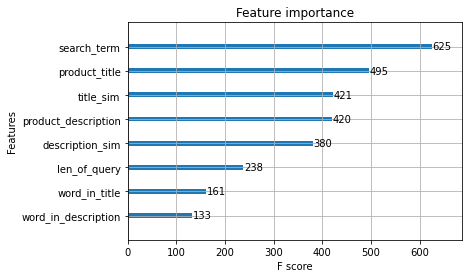

In [86]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
plot_importance(xg_reg)
plt.show() 

In [89]:
import lightgbm
mod_lgbm = lightgbm.LGBMRegressor(max_depth=3,learning_rate=0.1)
mod_lgbm.fit(X_train,y_train)
LGBM_preds=mod_lgbm.predict(X_test)

cv_scores_lgbm = cross_val_score(mod_lgbm, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

math.sqrt(-cv_scores_lgbm.mean())

0.4855965279163162